# Patterns for atlas acquisition within a given radius

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
%matplotlib inline

Here we set up the parameters and a mask of the area for acquisition.

In [2]:
full_radius_in_um = 990
atlas_radius_in_um = 600
atlas_imsize_x = 5700
atlas_imsize_y = 4096
pixel_size_in_angst = 650
pixel_size_um = 250/10_000
overlap = 0.05
imsize_x_um = atlas_imsize_x * pixel_size_um
imsize_y_um = atlas_imsize_y * pixel_size_um
imsize = np.array([imsize_x_um,imsize_y_um])

Divide the stage into tiles of different sizes and generate the mask. It's a padded array of zeros with 1s where we would like to acquire

In [3]:
def generate_tile_mask(radius:float,imsize_x_um:float,imsize_y_um:float, tile_overlap_fraction:float) -> np.ndarray:
    padded_max_axis = max([int(radius*2//imsize_x_um*(1-tile_overlap_fraction)), int(radius*2//imsize_y_um*(1-tile_overlap_fraction))]) + 2
    lattice_mask = np.zeros((padded_max_axis,padded_max_axis))
    center = np.array(lattice_mask.shape)//2
    lattice_stage = lattice_mask.copy()
    
    for x,xval in enumerate(lattice_mask):
        for y,yval in enumerate(xval):
            coord = (np.array([x,y])-center) * imsize
            dist = np.sqrt(np.sum(np.power(coord,2)))
            if dist > atlas_radius_in_um:
                continue
            lattice_mask[x,y] = 1
    return lattice_mask

lattice_mask = generate_tile_mask(radius=full_radius_in_um,imsize_x_um=imsize_x_um,imsize_y_um=imsize_y_um,tile_overlap_fraction=overlap)
center = np.array(lattice_mask.shape)//2
print(lattice_mask)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Spiral Pattern
This sections will generate a spiral pattern from the center of the stage outwards to cover the mask

In [4]:
def make_spiral_pattern_in_mask(mask:np.ndarray) -> List:
    start = np.array(mask.shape) // 2
    ind = 1
    movements = []
    while True:
        if ind+1 >= max(mask.shape):
            break
        
        for i in [np.array([1,0]),np.array([0,1])]:
            axis = np.where(i == 1)[0]
            temp_ind = ind
            if ind % 2 == 0:
                temp_ind *=-1
                
            end=start+(i*temp_ind)

            if start[0] == end[0]:
                order= np.sort(np.array([start[1],end[1]]))
                mov_slice = (start[0],slice(order[0],order[1],None))
            else:
                order= np.sort(np.array([start[0],end[0]]))
                mov_slice = (slice(order[0],order[1],None), start[1])

            if (mask[mov_slice] != 0).any():
                indexes = np.where(mask[mov_slice] == 1)[0]
                new_start, new_end = start.copy(), end.copy()
                new_start[axis] = start[axis]+indexes[0] if temp_ind > 0 else start[axis]-indexes[0]
                new_end[axis] = new_start[axis] + len(indexes) -1 if temp_ind > 0 else new_start[axis] - len(indexes) +1
                movements.append([new_start,new_end])
            start=end
        ind += 1 
    return movements

spiral_movments=make_spiral_pattern_in_mask(lattice_mask)

Then we plot back onto the map of the stage the different movements of the stage.

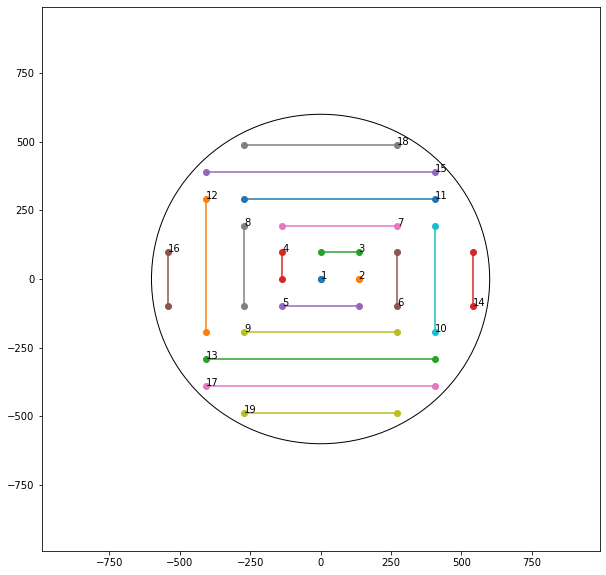

In [5]:
from matplotlib.patches import Circle, Rectangle
def plot_movements_on_stage(movements,imsize,overlap):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    limits = Circle([0,0],atlas_radius_in_um,fill=False)
    ax.add_patch(limits)
    ax.set_ylim(-full_radius_in_um,full_radius_in_um)
    ax.set_xlim(-full_radius_in_um,full_radius_in_um)
    for i, mov in enumerate(movements):
        a = (np.array(mov)-center) * imsize*(1-overlap)
        ax.text(a[0,0],a[0,1], i+1)
        ax.plot(a[:,0],a[:,1], marker='o')

plot_movements_on_stage(movements=spiral_movments,imsize=imsize,overlap=overlap)

## Serpent Pattern
This ones is more simple but reuses some pieces of the spiral logic

In [6]:
def make_serpent_pattern_in_mask(mask:np.ndarray) -> List:
    movement_direction = 1
    movements =[]
    for ind,line in enumerate(mask):
        if (line != 0).any():
            indexes = np.where(line == 1)[0]
            start = [ind,indexes[0] if movement_direction == 1 else indexes[-1]]
            end = [ind, indexes[-1] if movement_direction == 1 else indexes[0]]
            movements.append([start,end])
            movement_direction *= -1
    return movements
serpent_movements = make_serpent_pattern_in_mask(lattice_mask)

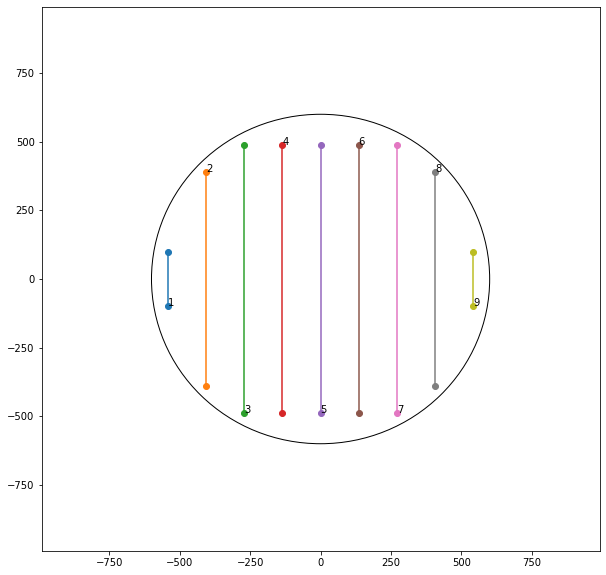

In [7]:
plot_movements_on_stage(serpent_movements,imsize,overlap)